In [ ]:
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Data Selection

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='IMDB-BINARY')

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].num_nodes}') # it was x
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: IMDB-BINARY(1000)
-------------------
Number of graphs: 1000
Number of nodes: 20
Number of features: 0
Number of classes: 2


## Graph Representation

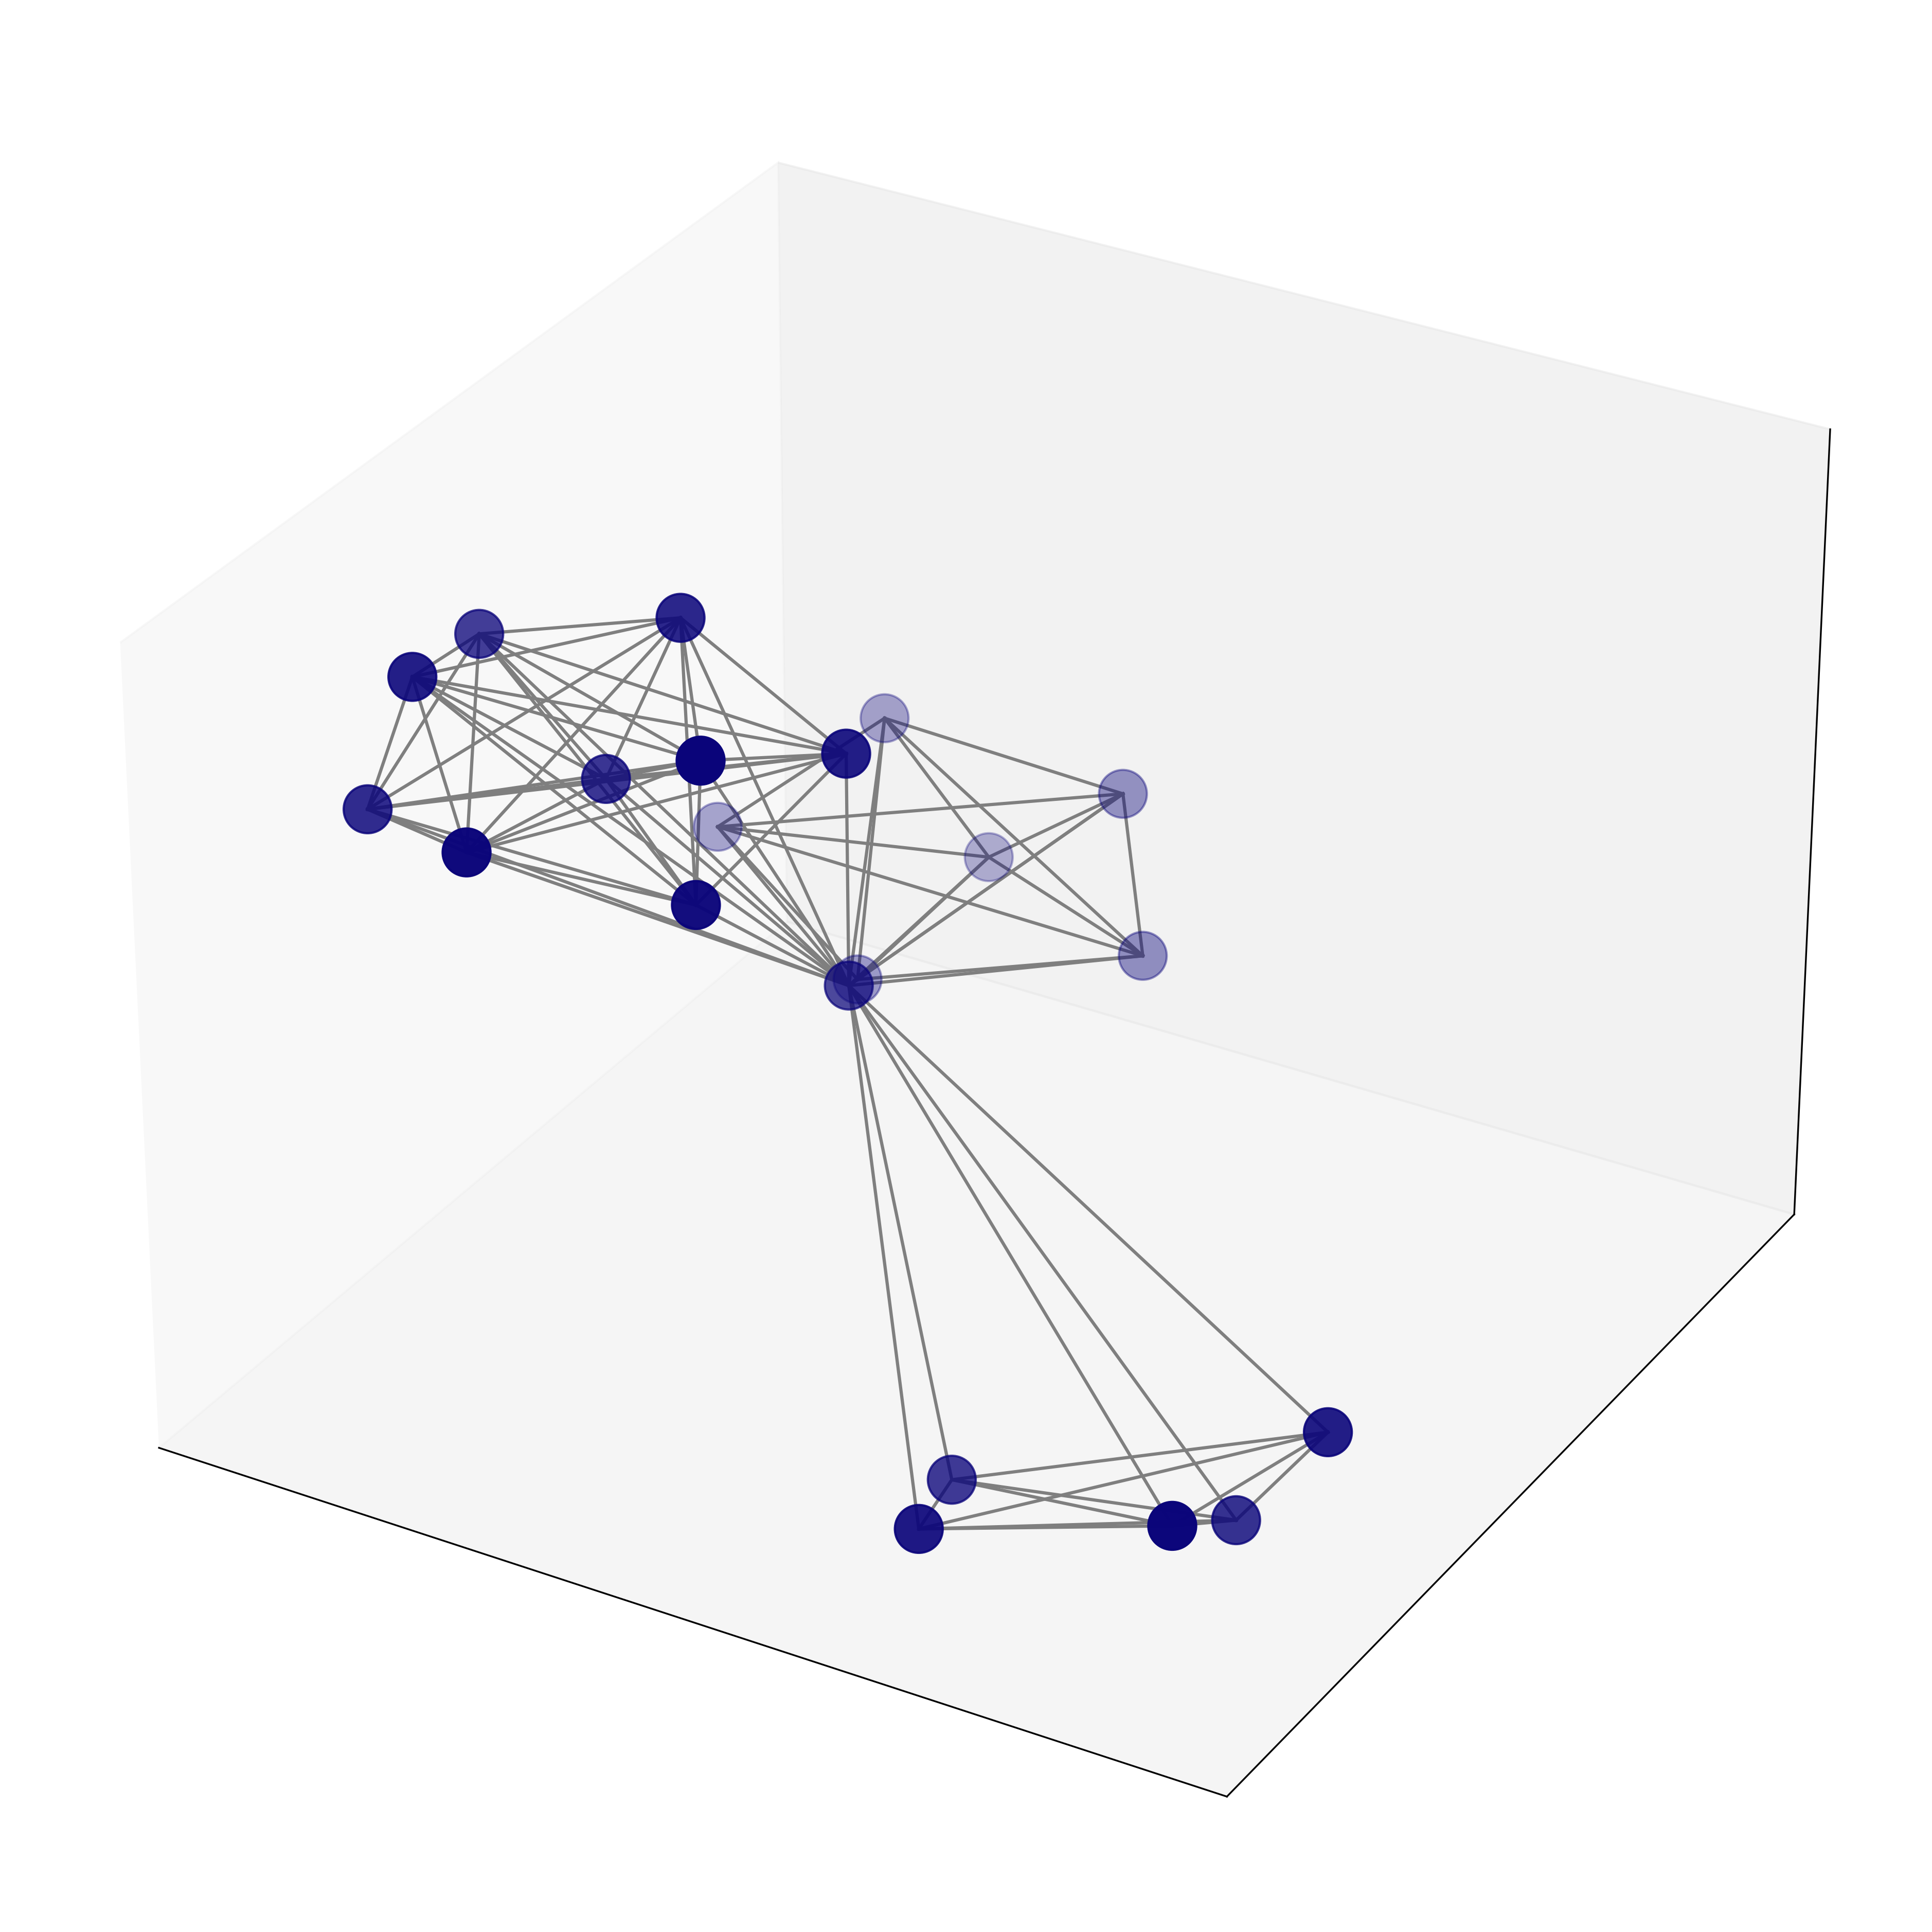

In [ ]:
from torch_geometric.utils import to_networkx,to_dense_batch, to_dense_adj
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

## Model

In [ ]:
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
from math import ceil
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, JumpingKnowledge
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, JumpingKnowledge, global_mean_pool as gap, global_max_pool as gmp, GCNConv, GINConv
from torch_geometric.data import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling


class GIN(torch.nn.Module):
    def __init__(self, num_features=1, num_classes=1, num_hidden=32):
        super(GIN, self).__init__()

        # if data.x is None:
        #   data.x = torch.ones([data.num_nodes, 1], dtype=torch.float)
        # dataset.data.edge_attr = None

        # num_features = dataset.num_features
        dim = num_hidden

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        nn6 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv6 = GINConv(nn6)
        self.bn6 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.leaky_relu(self.conv1(x, edge_index)) # leaky_relu. relu
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.leaky_relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = F.leaky_relu(self.conv6(x, edge_index))
        x = self.bn6(x)
        # x = global_add_pool(x, batch)
        x = global_mean_pool(x, batch)
        x = F.leaky_relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

### G-Mix up

In [ ]:
from time import time
import logging
#import os
#import os.path as osp
import numpy as np
import time
from torch_geometric.utils import degree
from torch.autograd import Variable

import random
from torch.optim.lr_scheduler import StepLR


#from utils import stat_graph, split_class_graphs, align_graphs
#from utils import two_graphons_mixup, universal_svd
#from graphon_estimator import universal_svd
#from models import GIN

import argparse

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s: - %(message)s', datefmt='%Y-%m-%d')



def prepare_dataset_x(dataset):
    if dataset[0].x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max( max_degree, degs[-1].max().item() )
            data.num_nodes = int( torch.max(data.edge_index) ) + 1

        if max_degree < 2000:
            # dataset.transform = T.OneHotDegree(max_degree)

            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = F.one_hot(degs, num_classes=max_degree+1).to(torch.float)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            for data in dataset:
                degs = degree(data.edge_index[0], dtype=torch.long)
                data.x = ( (degs - mean) / std ).view( -1, 1 )
    return dataset



def prepare_dataset_onehot_y(dataset):

    y_set = set()
    for data in dataset:
        y_set.add(int(data.y))
    num_classes = len(y_set)

    for data in dataset:
        data.y = F.one_hot(data.y, num_classes=num_classes).to(torch.float)[0]
    return dataset


def mixup_cross_entropy_loss(input, target, size_average=True):
    """Origin: https://github.com/moskomule/mixup.pytorch
    in PyTorch's cross entropy, targets are expected to be labels
    so to predict probabilities this loss is needed
    suppose q is the target and p is the input
    loss(p, q) = -\sum_i q_i \log p_i
    """
    assert input.size() == target.size()
    assert isinstance(input, Variable) and isinstance(target, Variable)
    loss = - torch.sum(input * target)
    return loss / input.size()[0] if size_average else loss




def train(model, train_loader):
    model.train()
    loss_all = 0
    graph_all = 0
    for data in train_loader:
        # print( "data.y", data.y )
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        y = data.y.view(-1, num_classes)
        loss = mixup_cross_entropy_loss(output, y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        graph_all += data.num_graphs
        optimizer.step()
    loss = loss_all / graph_all
    return model, loss


def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        y = data.y.view(-1, num_classes)
        loss += mixup_cross_entropy_loss(output, y).item() * data.num_graphs
        y = y.max(dim=1)[1]
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    loss = loss / total
    return acc, loss

In [ ]:
from typing import List, Tuple
from skimage.restoration import denoise_tv_chambolle
import numpy as np
import copy
import torch_geometric.transforms as T
from torch_geometric.utils import degree, to_dense_adj
import torch.nn.functional as F
import torch
import random

from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data


class NormalizedDegree(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        deg = degree(data.edge_index[0], dtype=torch.float)
        deg = (deg - self.mean) / self.std
        data.x = deg.view(-1, 1)
        # print( data.x.shape )
        return data


def prepare_synthetic_dataset(dataset):
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        for data in dataset:
            degs = degree(data.edge_index[0], dtype=torch.long)

            data.x = F.one_hot(degs.to(torch.int64), num_classes=max_degree+1).to(torch.float)
            print(data.x.shape)


        return dataset


def prepare_dataset(dataset):
    if dataset.data.x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        if max_degree < 1000:
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std)

    return dataset




def graph_numpy2tensor(graphs: List[np.ndarray]) -> torch.Tensor:
    """
    Convert a list of np arrays to a pytorch tensor
    :param graphs: [K (N, N) adjacency matrices]
    :return:
        graph_tensor: [K, N, N] tensor
    """
    graph_tensor = np.array(graphs)
    return torch.from_numpy(graph_tensor).float()










def split_class_x_graphs(dataset):

    y_list = []
    for data in dataset:
        y_list.append(tuple(data.y.tolist()))
        # print(y_list)
    num_classes = len(set(y_list))

    all_graphs_list = []
    all_node_x_list = []
    for graph in dataset:
        adj = to_dense_adj(graph.edge_index)[0].numpy()
        all_graphs_list.append(adj)
        all_node_x_list = [graph.x.numpy()]

    class_graphs = []
    for class_label in set(y_list):
        c_graph_list = [all_graphs_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
        c_node_x_list = [all_node_x_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
        class_graphs.append( ( np.array(class_label), c_graph_list, c_node_x_list ) )

    return class_graphs


def split_class_graphs(dataset):

    y_list = []
    for data in dataset:
        y_list.append(tuple(data.y.tolist()))
        # print(y_list)
    num_classes = len(set(y_list))

    all_graphs_list = []
    for graph in dataset:
        adj = to_dense_adj(graph.edge_index)[0].numpy()
        all_graphs_list.append(adj)

    class_graphs = []
    for class_label in set(y_list):
        c_graph_list = [all_graphs_list[i] for i in range(len(y_list)) if y_list[i] == class_label]
        class_graphs.append( ( np.array(class_label), c_graph_list ) )

    return class_graphs




def stat_graph(graphs_list: List[Data]):
    num_total_nodes = []
    num_total_edges = []
    for graph in graphs_list:
        num_total_nodes.append(graph.num_nodes)
        num_total_edges.append(  graph.edge_index.shape[1] )
    avg_num_nodes = sum( num_total_nodes ) / len(graphs_list)
    avg_num_edges = sum( num_total_edges ) / len(graphs_list) / 2.0
    avg_density = avg_num_edges / (avg_num_nodes * avg_num_nodes)

    median_num_nodes = np.median( num_total_nodes )
    median_num_edges = np.median(num_total_edges)
    median_density = median_num_edges / (median_num_nodes * median_num_nodes)

    return avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density

## Calling G-mixup

avg num nodes of training graphs: 19.524285714285714
avg num edges of training graphs: 94.00857142857143
avg density of training graphs: 0.24661366890692205
median num nodes of training graphs: 16.0
median num edges of training graphs: 130.0
median density of training graphs: 0.5078125
num_features: torch.Size([15, 136])
num_classes: torch.Size([2])
train_dataset size: 700
val_dataset size: 100
test_dataset size: 200
Epoch: 001, Train Loss: 0.714302, Val Loss: 1.260594, Test Loss: 1.949656,  Val Acc:  0.680000, Test Acc:  0.605000
Epoch: 002, Train Loss: 0.635456, Val Loss: 0.654158, Test Loss: 0.617109,  Val Acc:  0.600000, Test Acc:  0.620000
Epoch: 003, Train Loss: 0.611663, Val Loss: 0.598392, Test Loss: 0.538973,  Val Acc:  0.650000, Test Acc:  0.700000
Epoch: 004, Train Loss: 0.651457, Val Loss: 0.581651, Test Loss: 0.593738,  Val Acc:  0.660000, Test Acc:  0.665000
Epoch: 005, Train Loss: 0.620102, Val Loss: 0.682044, Test Loss: 0.724089,  Val Acc:  0.700000, Test Acc:  0.700000

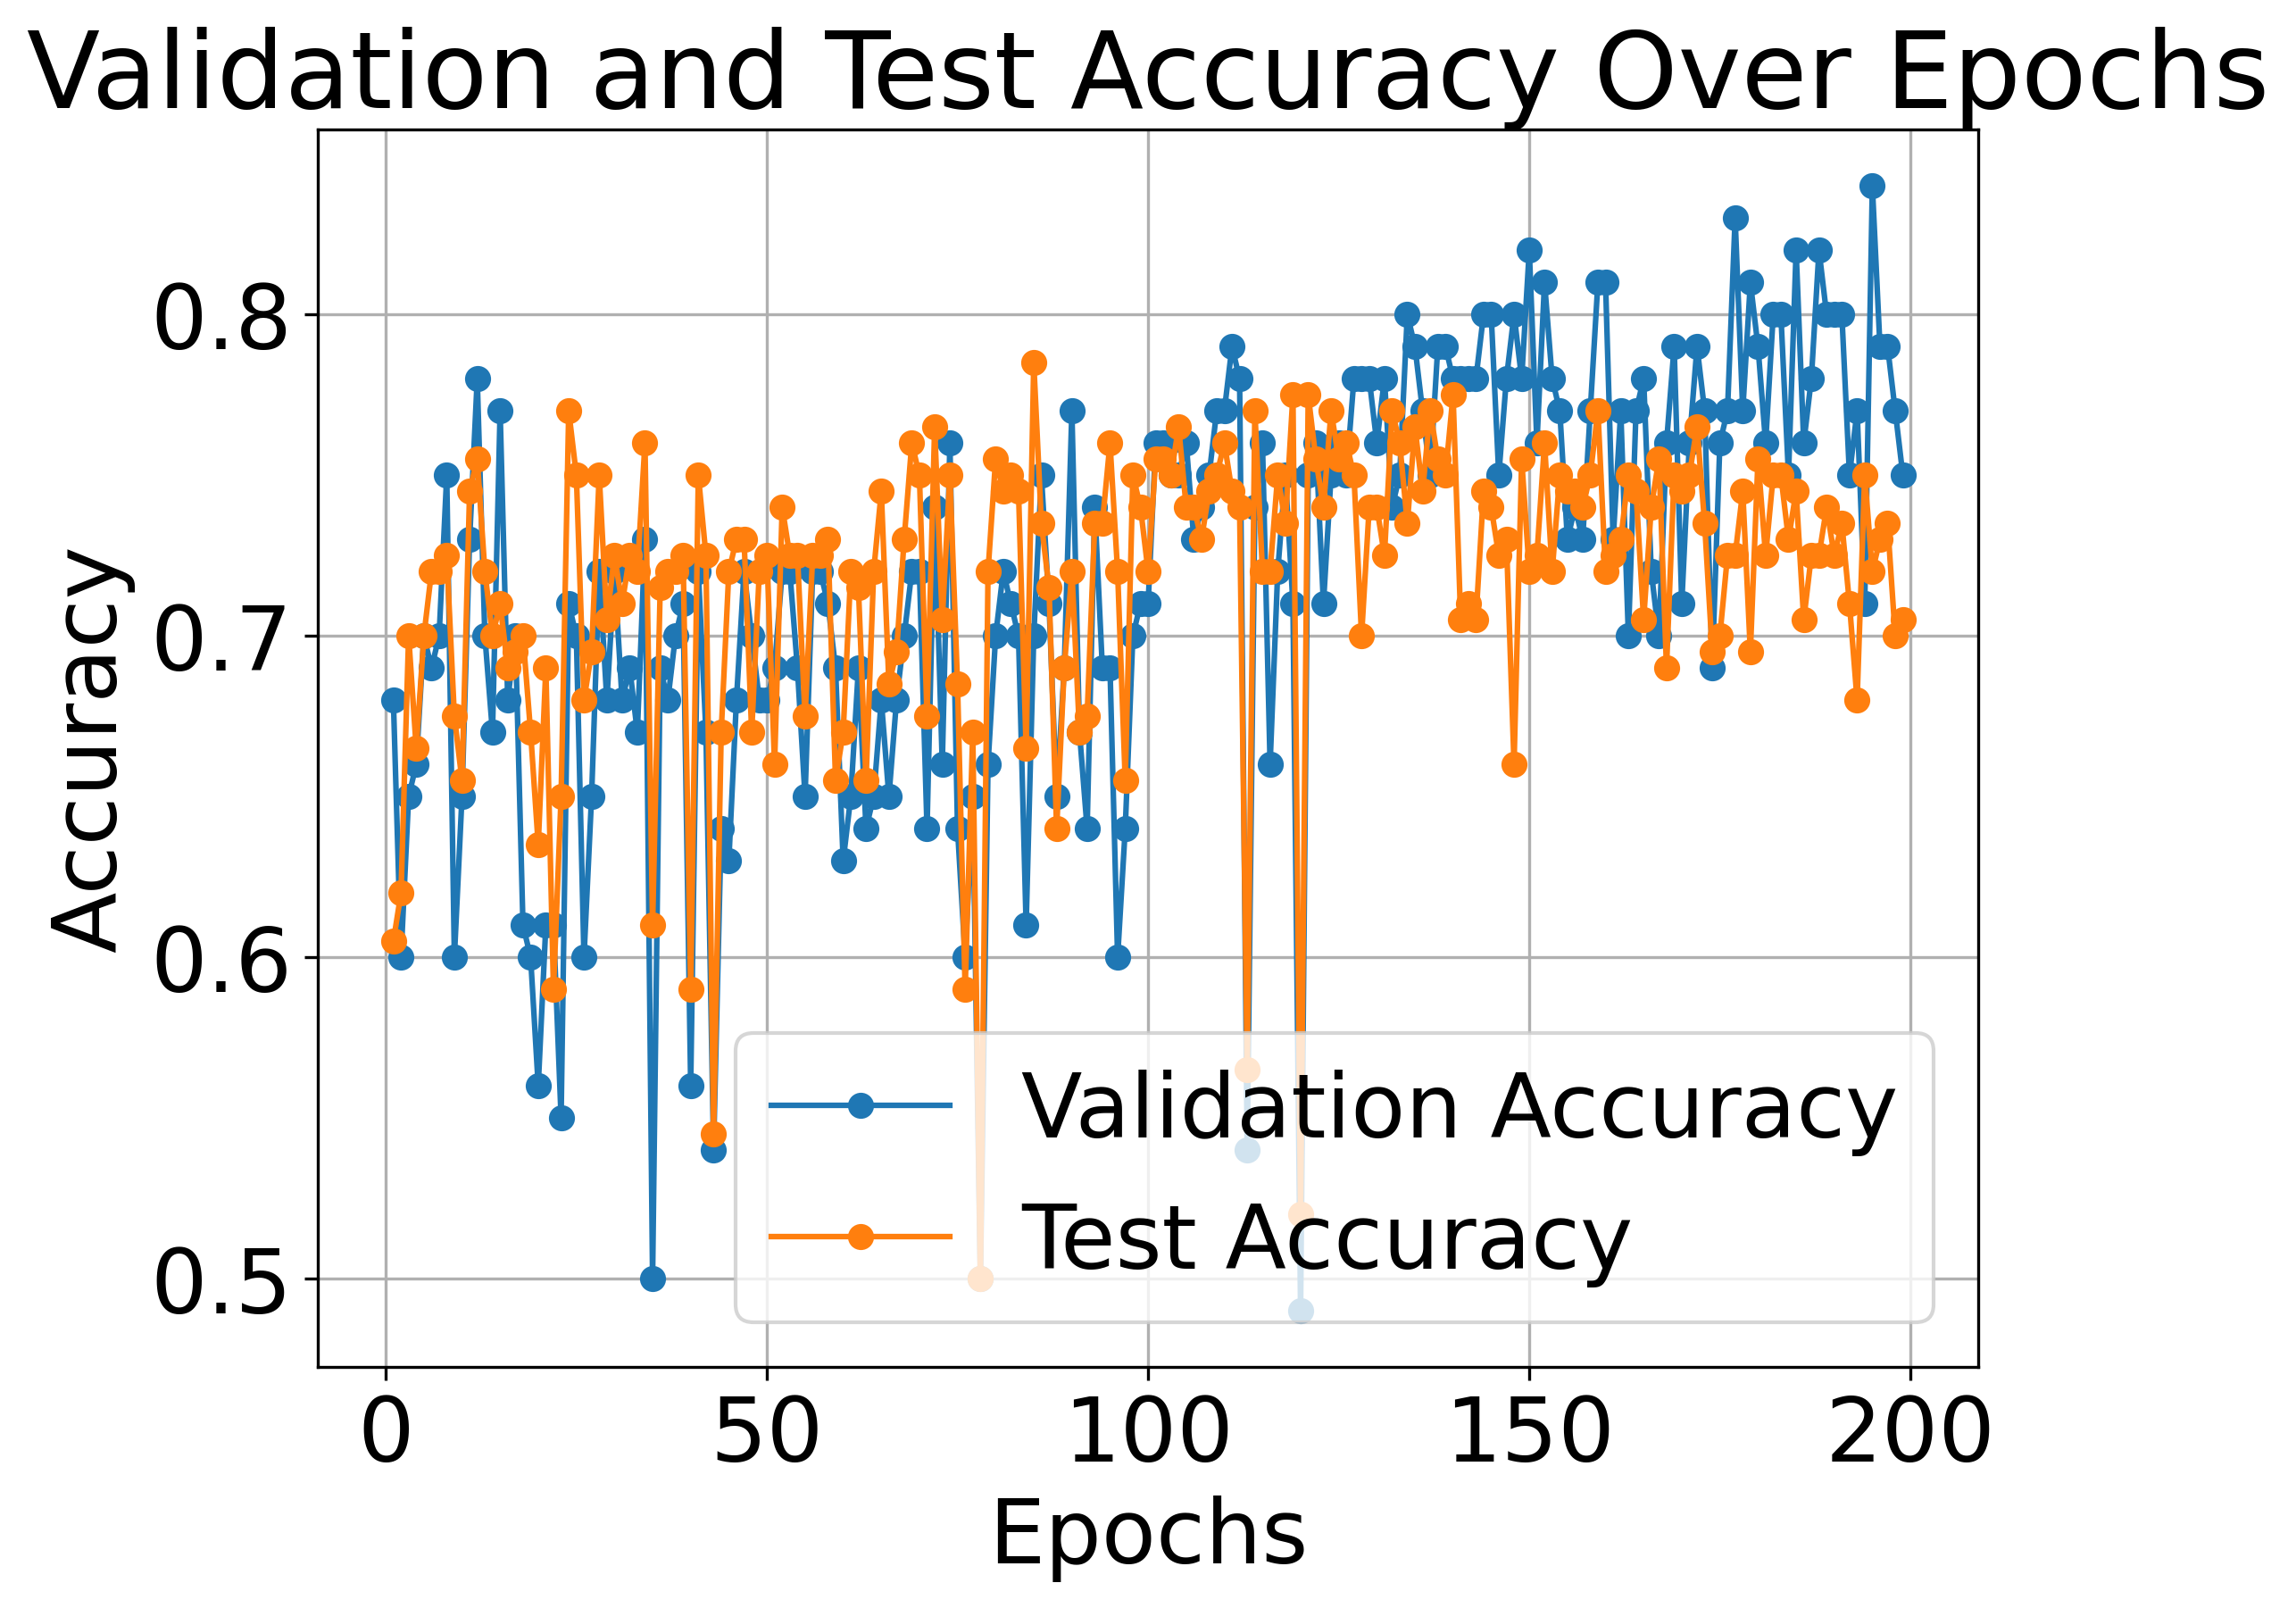

In [ ]:
lam_range = [0.005, 0.01]
gmixup = False
num_epochs = 200

num_hidden = 128
batch_size = 32
learning_rate = 0.01
ge = "MC"
aug_ratio = 0.15
aug_num = 10
model = "GIN"
device = "cpu"

dataset = list(dataset)

for graph in dataset:
    graph.y = graph.y.view(-1)

dataset = prepare_dataset_onehot_y(dataset)

random.shuffle( dataset )

train_nums = int(len(dataset) * 0.7)
train_val_nums = int(len(dataset) * 0.8)

avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(dataset[: train_nums])
print(f"avg num nodes of training graphs: { avg_num_nodes }")
print(f"avg num edges of training graphs: { avg_num_edges }")
print(f"avg density of training graphs: { avg_density }")
print(f"median num nodes of training graphs: { median_num_nodes }")
print(f"median num edges of training graphs: { median_num_edges }")
print(f"median density of training graphs: { median_density }")

resolution = int(median_num_nodes)



dataset = prepare_dataset_x( dataset )

print(f"num_features: {dataset[0].x.shape}" )
print(f"num_classes: {dataset[0].y.shape}"  )

num_features = dataset[0].x.shape[1]
num_classes = dataset[0].y.shape[0]

train_dataset = dataset[:train_nums]
random.shuffle(train_dataset)
val_dataset = dataset[train_nums:train_val_nums]
test_dataset = dataset[train_val_nums:]

print(f"train_dataset size: {len(train_dataset)}")
print(f"val_dataset size: {len(val_dataset)}")
print(f"test_dataset size: {len(test_dataset)}" )


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


if model == "GIN":
    model = GIN(num_features=num_features, num_classes=num_classes, num_hidden=num_hidden).to(device)
else:
    print(f"No model."  )


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

total_acc = 0
validation_accuracy=[]
test_accuracy =[]
for epoch in range(1, num_epochs):
    model, train_loss = train(model, train_loader)
    train_acc = 0
    val_acc, val_loss = test(model, val_loader)
    test_acc, test_loss = test(model, test_loader)
    validation_accuracy.append(val_acc)
    test_accuracy.append(test_acc)
    total_acc += test_acc
    scheduler.step()

    print('Epoch: {:03d}, Train Loss: {:.6f}, Val Loss: {:.6f}, Test Loss: {:.6f},  Val Acc: {: .6f}, Test Acc: {: .6f}'.format(
        epoch, train_loss, val_loss, test_loss, val_acc, test_acc))

print(f'\n Avg Accuracy:     {(total_acc / num_epochs)*100:.2f}%')
epochs = range(1, num_epochs)  # Replace with the actual number of training epochs
# validation_accuracy = [0.85, 0.88, 0.90, 0.91, 0.92, 0.92, 0.93, 0.94, 0.94, 0.95]  # Replace with your values
# test_accuracy = [0.83, 0.87, 0.89, 0.90, 0.91, 0.91, 0.92, 0.93, 0.93, 0.94]  # Replace with your values

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='o')
plt.title('Validation and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
